# Sparse Hebbian Learning: toward a quantitative measure of the quality of filters

We are interested here in learning the "optimal" components of a set of images (let's say some "natural", usual images). As there is no supervisor to guide the learning, this is called unsupervised learning. Our basic hypothesis to find the best ("optimal") components will be to assume that *a priori* the most sparse is more plausible. We will implement the derived algorithm in this set of scripts.



In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(precision=4, suppress=True)

## experiments

To test and control for the role of different parameters, we will have a first object (in the [shl_experiments.py](https://github.com/bicv/SparseHebbianLearning/blob/master/shl_scripts/shl_experiments.py) script) that controls a learning experiment. It contains all relevant parameters, but can also keep a trace of the history of some statistics. This is useful to compare the relative efficiency of the different solutions.


In [3]:
tag = 'coding'
homeo_methods = ['None', 'HAP', 'HEH']


record_num_batches = 2**12

seed = 42
np.random.seed(seed)

from shl_scripts.shl_experiments import SHL
shl = SHL()
data = shl.get_data(matname=tag + '_test')
indx = np.random.permutation(data.shape[0])[:record_num_batches]

list_figures = []

dico = {}
for homeo_method in homeo_methods:
    print(19*'🐶' + homeo_method + 10*'🐶')
    shl = SHL(homeo_method=homeo_method)
    dico[homeo_method] = shl.learn_dico(data=data, list_figures=list_figures, matname=tag + '_' + homeo_method)


🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶None🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶
🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶HAP🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶
🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶HEH🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶


## theory



In [4]:
from scipy.stats import binom
# define the mean
rho = shl.l0_sparseness / shl.n_dictionary

# draw binomial samples
sparse_code_binary = np.random.rand(record_num_batches, shl.n_dictionary) > 1 - rho

In [5]:
print('Sum of non-zero coefficients', sparse_code_binary.sum(), '~=', shl.l0_sparseness*record_num_batches)
print('average non-zeros', np.count_nonzero(sparse_code_binary, axis=0).mean(), '~=', rho*record_num_batches)
print('activation vector', np.count_nonzero(sparse_code_binary, axis=0))

Sum of non-zero coefficients 57293 ~= 57344
average non-zeros 129.91609977324262 ~= 130.03174603174602
activation vector [128 119 133 117 136 112 133 116 125 146 132 127 122 128 157 135 140 151
 134 138 111 133 121 127 133 111 136 120 124 125 139 111 115 122 119 146
 139 135 128 130 128 130 106 135 141 114 127 152 110 130 141 123 128 125
 143 121 132 109 121 132 128 138 137 124 134 118 120 134 129 126 135 135
 136 141 137 113 132 144 138 134 146 114 120 132 125 115 123 138 134 146
 125 138 127 121 125 149 133 117 130 130 128 140 123 118 143 126 131 124
 128 129 129 124 135 130 131 126 143 125 127 119 145 125 130 122 124 127
 121 122 135 110 126 141 128 126 144 128 123 135 118 114 133 153 113 136
 122 126 124 123 139 136 115 133 139 144 127 153 132 133 120 140 148 143
 135 139 124 132 133 134 136 142 125 123 123 142 128 119 118 126 124 119
 117 148 131 117 138 106 116 122 133 118 123 128 139 147 148 139 142 132
 133 111 150 137 137 134 139 117 128 135 146 125 135 118 119 129 141 136
 11

Shape of co-occurrences (4096, 441, 441)
activation vector [[128   7   7 ...   5   2   1]
 [  7 119   3 ...   3   5   4]
 [  7   3 133 ...   8   2   6]
 ...
 [  5   3   8 ... 139   5   5]
 [  2   5   2 ...   5 112   4]
 [  1   4   6 ...   5   4 124]]
marginal activation vector [4.4399 4.0975 4.6122 3.932  4.5238 3.7415 4.4785 3.7846 4.2812 4.8526
 4.4263 4.2063 4.0952 4.322  5.3243 4.78   4.7007 5.3265 4.3673 4.6848
 3.7959 4.381  4.0023 4.4399 4.5034 3.6893 4.4467 4.0408 4.1701 4.3016
 4.7664 3.6735 3.7755 4.1769 4.1066 4.7483 4.8073 4.5057 4.3356 4.4694
 4.5034 4.2744 3.7188 4.6032 4.7052 3.7687 4.3265 5.2721 3.7687 4.424
 4.7166 4.2766 4.2086 4.2404 4.8753 4.161  4.6145 3.6032 3.9909 4.3719
 4.263  4.5601 4.6327 4.1905 4.4785 3.9252 4.0227 4.4036 4.3333 4.2222
 4.6327 4.4762 4.5646 4.9229 4.7211 3.9093 4.5351 4.7732 4.6009 4.585
 4.9546 3.737  3.9683 4.4444 4.3288 3.9909 4.068  4.6122 4.3787 5.
 4.2086 4.8458 4.2585 4.1066 4.1995 4.9909 4.6304 4.0045 4.2721 4.5057
 4.288  4.8073 4.0

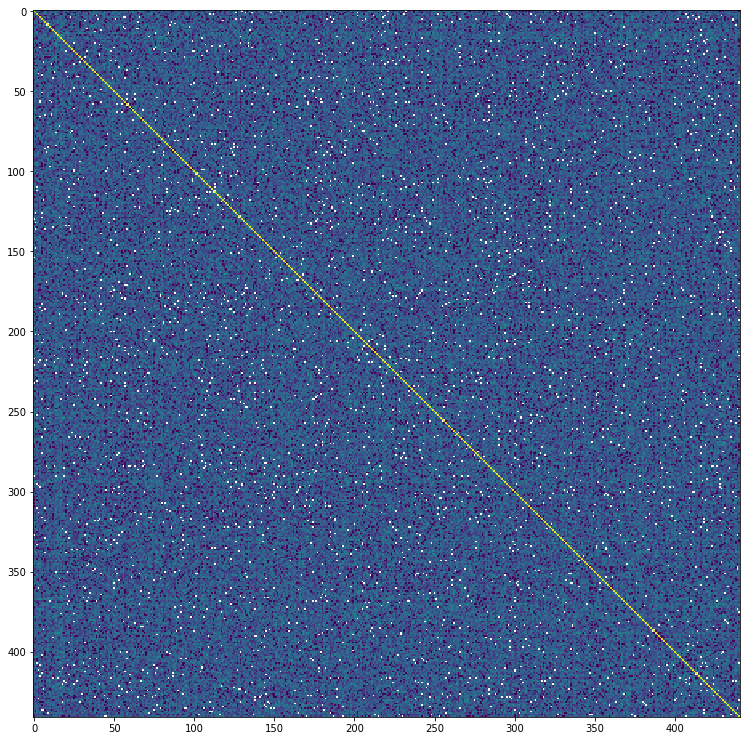

In [6]:
b_ij = (sparse_code_binary[:, np.newaxis, :]>0) * (sparse_code_binary[:, :, np.newaxis]>0)
print('Shape of co-occurrences', b_ij.shape)
print('activation vector', np.count_nonzero(b_ij, axis=0))
fig, ax= plt.subplots(figsize=(13, 13))
ax.imshow(np.log(np.count_nonzero(b_ij, axis=0)));
print('marginal activation vector', np.count_nonzero(b_ij, axis=0).mean(axis=-1))

Min-Max -2.6523245205527386e-06 0.0005864364263619619


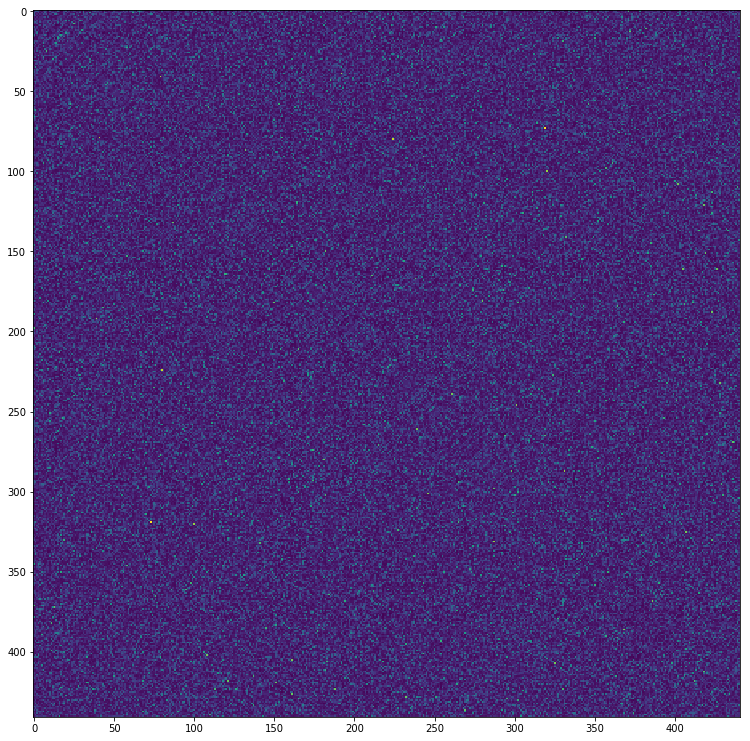

In [7]:
b_ij = (sparse_code_binary[:, np.newaxis, :]>0) * (sparse_code_binary[:, :, np.newaxis]>0)
P_ij = 1.*np.count_nonzero(b_ij, axis=0)
P_ij /= P_ij.sum()
P_i = 1.*np.count_nonzero(sparse_code_binary, axis=0)
P_i /= P_i.sum()
fig, ax= plt.subplots(figsize=(13, 13))
MI_ = - (P_ij * np.log( P_i[:, np.newaxis]*P_i[np.newaxis, :] / P_ij  ))
MI_[P_ij==0] = 0
MI_[(P_i[:, np.newaxis]*P_i[np.newaxis, :])==0] = 0
print('Min-Max', MI_.min(), MI_.max())
np.fill_diagonal(MI_, 0)
ax.imshow(MI_);

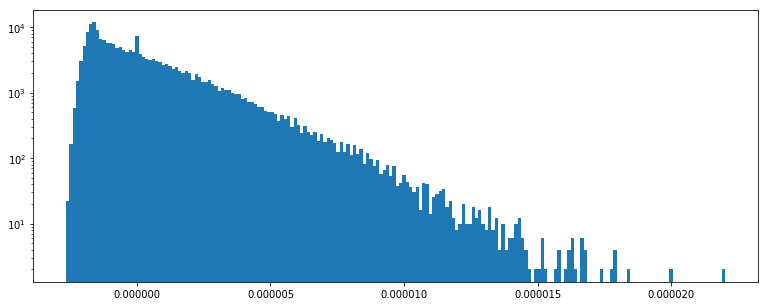

In [8]:
fig, ax= plt.subplots(figsize=(13, 5))
ax.hist(MI_.ravel(), bins=200)
ax.set_yscale('log');

In [9]:
from shl_scripts.shl_tools import get_MI
MI_theory = []
for _ in range(10):
    sparse_code_binary = np.random.rand(record_num_batches, shl.n_dictionary) > 1 - rho
    MI = get_MI(sparse_code_binary)
    print ('Mutual information for random sample=', MI)
    MI_theory.append(MI)
MI_theory = np.array(MI_theory)

Mutual information for random sample= 0.2815633237929789
Mutual information for random sample= 0.2757127197542228
Mutual information for random sample= 0.27731436221844435
Mutual information for random sample= 0.27366927982507555
Mutual information for random sample= 0.2783870134121254
Mutual information for random sample= 0.28041391413455863
Mutual information for random sample= 0.2771512192410718
Mutual information for random sample= 0.2719077219823317
Mutual information for random sample= 0.27528912394894095
Mutual information for random sample= 0.2772549092116697


## coding

The learning itself is done via a gradient descent but is highly dependent on the coding / decoding algorithm. This belongs to a another function (in the [shl_encode.py](https://github.com/bicv/SparseHebbianLearning/blob/master/shl_scripts/shl_encode.py) script)

In [10]:
from shl_scripts.shl_encode import sparse_encode
sparse_code = {}
for homeo_method in homeo_methods:
    print(15*'🐶' + homeo_method[:3] + 15*'🐶')
    if dico[homeo_method].P_cum is None: 
        gain = np.ones(shl.n_dictionary)
    else:
        gain = None
    sparse_code[homeo_method] = sparse_encode(data[indx, :], dico[homeo_method].dictionary, precision=dico[homeo_method].precision, 
#                                              P_cum=dico[homeo_method].P_cum, gain=None, 
                                              P_cum=None, gain=np.ones(shl.n_dictionary),

                                              l0_sparseness = shl.l0_sparseness, C=shl.C)
    # from shl_scripts.shl_tools import print_stats
    # SD, SE = print_stats(data[indx, :], dico[homeo_method].dictionary, sparse_code[homeo_method])

🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶Non🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶
🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶HAP🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶
🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶HEH🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶


## measuring the distance to independance 

In [11]:
print ('Mutual information for theory=', MI_theory.mean(), '+/-', MI_theory.std())
#fig, ax= plt.subplots(figsize=(13, 5))
for homeo_method in homeo_methods:
    print(15*'🐶' + homeo_method[:3] + 15*'🐶')
    MI = get_MI(sparse_code[homeo_method])
    print ('Mutual information for homeo_method=', homeo_method, 'is', MI)

Mutual information for theory= 0.27686635875214194 +/- 0.0027571686435075627
🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶Non🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶
Mutual information for homeo_method= None is 0.3462446999453134
🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶HAP🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶
Mutual information for homeo_method= HAP is 0.3449413453491211
🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶HEH🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶
Mutual information for homeo_method= HEH is 0.3430562617429034


## Version used

In [12]:
%load_ext version_information
%version_information shl_scripts, numpy, shl_scripts, pandas, matplotlib

Software versions
Python 3.6.5 64bit [GCC 4.2.1 Compatible Apple LLVM 9.1.0 (clang-902.0.39.2)]
IPython 6.5.0
OS Darwin 17.7.0 x86_64 i386 64bit
shl_scripts 20171221
numpy 1.15.1
shl_scripts 20171221
pandas 0.23.4
matplotlib 3.0.0
Tue Sep 25 11:37:49 2018 CEST